In [1]:
%pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185348 sha256=8d35ce3b36ac90edd712fec6da428c4e2aa8f2930a037812fad987b2cda8f3eb
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
channels = 64
seconds = 0.5
fs = 256.0
data_portion = 1
save_model = False

In [3]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "kaggle/working/eegdataset/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)


In [4]:
import os
import shutil

# Specify the paths
source_file = '/kaggle/input/eegdataset/features_raw.csv/features_raw.csv'
destination_directory = 'kaggle/working/eegdataset/'
destination_file = os.path.join(destination_directory, "features_raw.csv")

# Copy the file to the destination directory
shutil.copy(source_file, destination_file)


'kaggle/working/eegdataset/features_raw.csv'

In [5]:
df = pd.read_csv("kaggle/working/eegdataset/features_raw.csv")
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


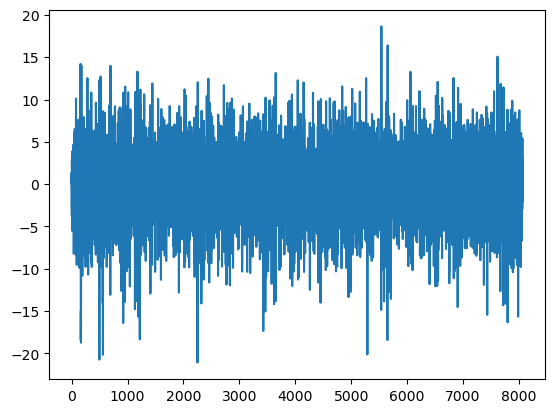

In [6]:
plt.plot(df['Fp1'])

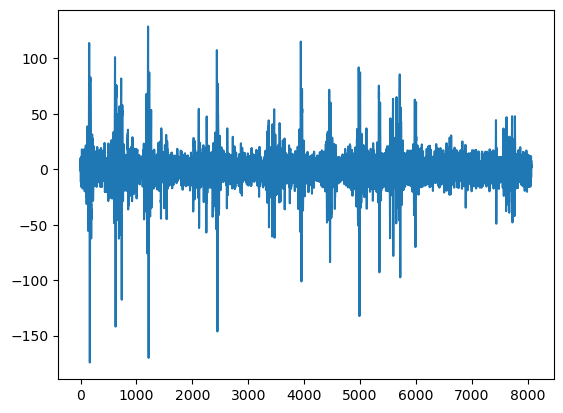

In [7]:
plt.plot(df['AF3'])

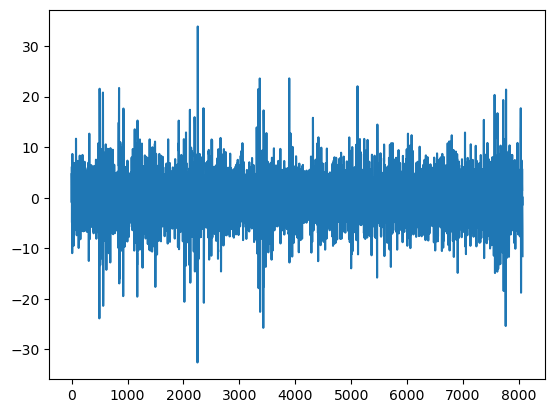

In [8]:
plt.plot(df['F3'])

In [9]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [10]:
train_csv = 'kaggle/working/eegdataset/features_raw.csv'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [11]:
train_dataset.shape

(2016, 128)

In [12]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

print("="*20)
print("TRAINING THE MODEL")

TRAINING THE MODEL


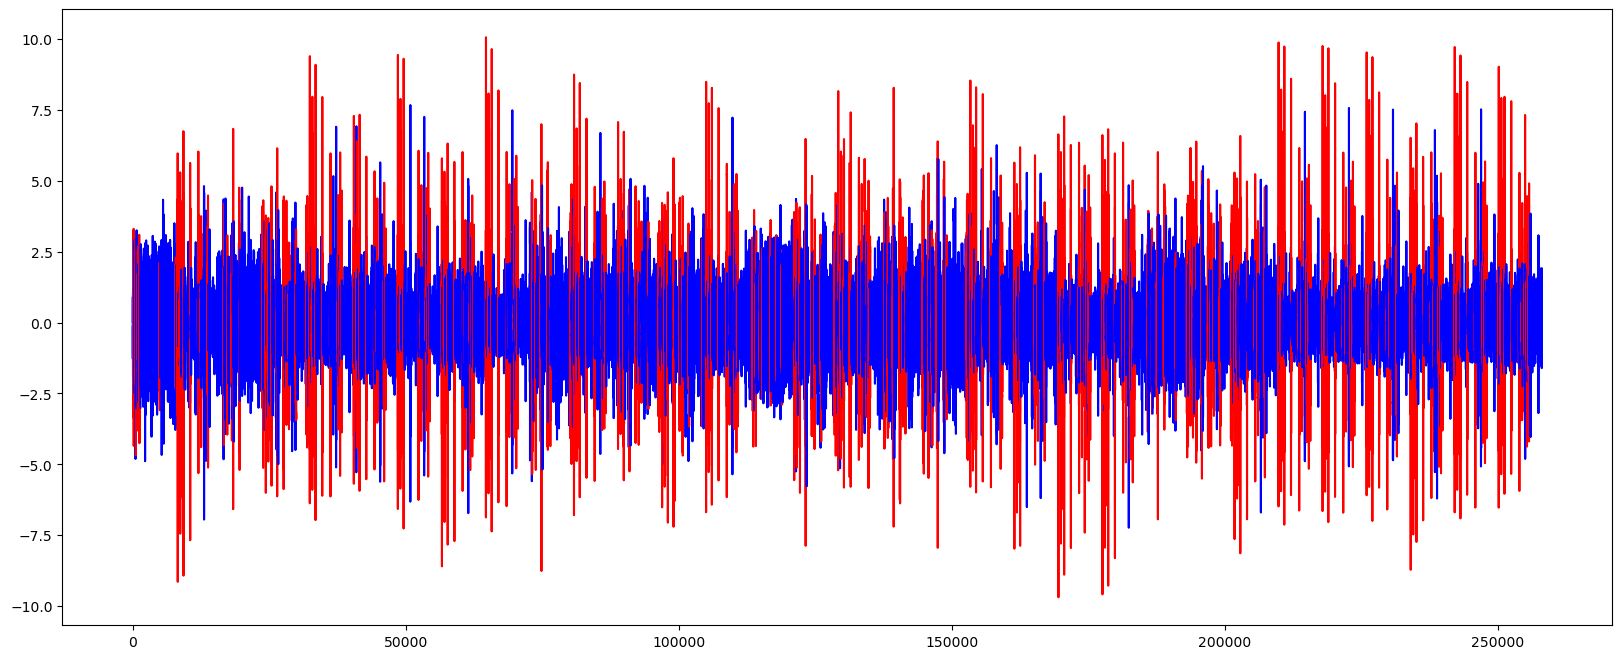

In [13]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):
    plt.rcParams["figure.figsize"] = (20,8)

    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [14]:

!pip install --upgrade scikit-learn

!pip install matplotlib seaborn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
#tf.keras.backend.clear_session()
#from sklearn.metrics import plot_confusion_matrix
#from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/eegdataset/features_raw.csv/features_raw.csv
/kaggle/input/eegdataset/emotions.csv/emotions.csv


In [15]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "kaggle/working/eegdataset2/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)

In [16]:
import os
import shutil

# Specify the paths
source_file = '/kaggle/input/eegdataset/emotions.csv/emotions.csv'
destination_directory = 'kaggle/working/eegdataset2/'
destination_file = os.path.join(destination_directory, "emotions.csv")

# Copy the file to the destination directory
shutil.copy(source_file, destination_file)

'kaggle/working/eegdataset2/emotions.csv'

In [17]:
import pandas as pd

data = pd.read_csv("kaggle/working/eegdataset2/emotions.csv")
data.head()

#file_path = "../input/eeg-brainwave-dataset-feeling-emotions/sentiment_labels.txt"

# Open the file in read mode ('r')
#with open(file_path, 'r') as file:
    # Read the content of the file
    #data = file.read()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [18]:
len(data)

2132

In [19]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [20]:
x_train.shape[1]

2548

In [21]:
import tensorflow as tf

def create_model_with_attention():
    inputs = tf.keras.Input(shape=(x_train.shape[1],))

    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    
    #gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru)
    
    # Attention Mechanism
    attention = tf.keras.layers.Attention()([gru, gru])  # Applying self-attention
    
    # Global Average Pooling to capture important features
    attention_pooling = tf.reduce_mean(attention, axis=1)
    
    # Output Layer
    outputs = tf.keras.layers.Dense(3, activation='softmax')(attention_pooling)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [22]:
import tensorflow as tf

# Create the model
lstmmodel = create_model_with_attention()

# Compile the model (you can use your own optimizer, loss, and metrics)
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.2,             # Factor by which the learning rate will be reduced (new_lr = old_lr * factor)
    patience=5,             # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001          # Lower bound on the learning rate
)

# Train the model with the ReduceLROnPlateau callback
history = lstmmodel.fit(
    x_train, y_train,
    batch_size=channels,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr]  # Include the callback in the list
)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2548)]       0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 2548, 1)      0           ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 2548, 256)    198912      ['tf.expand_dims[0][0]']         
                                                                                                  
 attention (Attention)          (None, 2548, 256)    0           ['gru[0][0]',                    
                                                                  'gru[0][0]']                

In [23]:
#Loss and accuracy
loss, acc = lstmmodel.evaluate(x_test, y_test)

14/14 [==============================] - 1s 79ms/step - loss: 0.1015 - accuracy: 0.9602


In [24]:
from sklearn.metrics import precision_score

y_pred = lstmmodel.predict(x_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

#Precision
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')

14/14 [==============================] - 1s 77ms/step


In [25]:
from sklearn.metrics import recall_score, f1_score

#recall
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

#F1-score
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

In [26]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np

#balanced accuracy
balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)

#geometric mean
sensitivity = recall_score(y_true_labels, y_pred_labels, average='weighted')
specificity = balanced_acc
g_mean = np.sqrt(sensitivity * specificity)

In [27]:
#Weighted Metrics
print(f"Loss on testing: {loss}",f"\nAccuracy on Training: {acc*100}")
print(f'Precision: {precision*100}')
print(f'Recall: {recall*100}')
print(f'F1-score: {f1*100}')
print(f'Balanced Accuracy: {balanced_acc*100}')
print(f'Geometric Mean: {g_mean*100}')


Loss on testing: 0.1014966145157814 
Accuracy on Training: 96.01873755455017
Precision: 96.26548525203657
Recall: 96.01873536299766
F1-score: 96.00567599111851
Balanced Accuracy: 96.00848306316409
Geometric Mean: 96.01360907623875


In [28]:
#metrics for each class

from sklearn.metrics import classification_report

class_report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.98      0.89      0.94       142
           2       0.90      0.99      0.95       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [29]:
pred  = lstmmodel.predict(x_test)

14/14 [==============================] - 1s 77ms/step


In [30]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
import numpy as np

pred1 = np.argmax(pred,axis=1)

In [32]:
y_test1 =   np.argmax(y_test,axis=1)

In [33]:
#printing first 1000 Actual and predicted outputs of Test brain signals
print("Predicted:  ",pred1[:1000])
print("\n")
print("Actual: ",y_test1[:1000])

Predicted:   [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 0 0 0 1 0 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 1 1 2 1 0 2 2 0 2 2 1 0 2 0 1 1 1 2 0 2 0 2 2 1 0 0 1 2 2 2 0 1 2 0 0 0 2
 1 1 0 1 1 2 2 0 1 1 1 2 1 1 0 2 1 1 0 2 0 1 0 0 0 1 2 1 2 0 0 2 0 2 0 2 0
 1 1 2 1 0 2 1 2 2 0 2 1 0 2 2 0 2 0 2 2 0 1 2 2 2 0 0 2 1 2 1 2 0 1 1 2 0
 0 2 0 2 2 2 2 1 1 1 2 2 2 0 0 1 2 1 2 1 2 1 1 1 0 2 1 1 0 1 0 2 0 1 0 1 0
 2 0 0 0 0 2 2 1 1 0 2 1 2 2 2 0 0 2 2 0 0 0 0 2 1 1 0 2 0 0 0 2 1 1 0 1 0
 0 1 0 1 0 2 0 2 0 2 2 1 2 2 0 0 2 1 1 1 1 0 0 0 1 2 0 1 2 2 2 1 1 1 1 2 1
 0 0 0 0 1 0 1 1 1 2 0 0 1 2 2 1 2 1 0 0 1 2 0 2 2 1 0 2 0 0 2 2 2 0 0 0 0
 0 1 2 2 1 0 2 1 0 0 1 2 2 0 0 1 0 0 2 1 0 0 2 2 0 2 1 0 0 1 1 1 2 2 2 0 2
 0 2 2 2 1 2 2 1 2 2 0 1 2 0 0 2 1 0 0 1 2 1 1 0 0 0 2 2 1 0 1 0 1 2 2 0 1
 0 2 0 1 2 1 0 2 0 0 2 2 2 0 1 0 0 1 1 2 2 2 0 1 0 0 1 0 0 1 1 0 0 1 2 2 0
 1 2 2 0 0 0 1 1 0 2 0 2 1 2 2 2 1 2 0 1]


Actual:  [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 0 0 0 1 0 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 1 1 2 1 0 2 2 0 2 1 1 0 2 0 1 1 1

In [34]:
names1 = ["Neutral","Positive","Negative"]

In [35]:
print("Neutral: 0 ","Positive: 1","Negative: 2")

Neutral: 0  Positive: 1 Negative: 2


ROC Curve 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2548)]       0           []                               
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 2548, 1)      0           ['input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 2548, 256)    198912      ['tf.expand_dims_1[0][0]']       
                                                                                                  
 attention_1 (Attention)        (None, 2548, 256)    0           ['gru_1[0][0]',                  
                                                                  'gru_1[0][0]']            

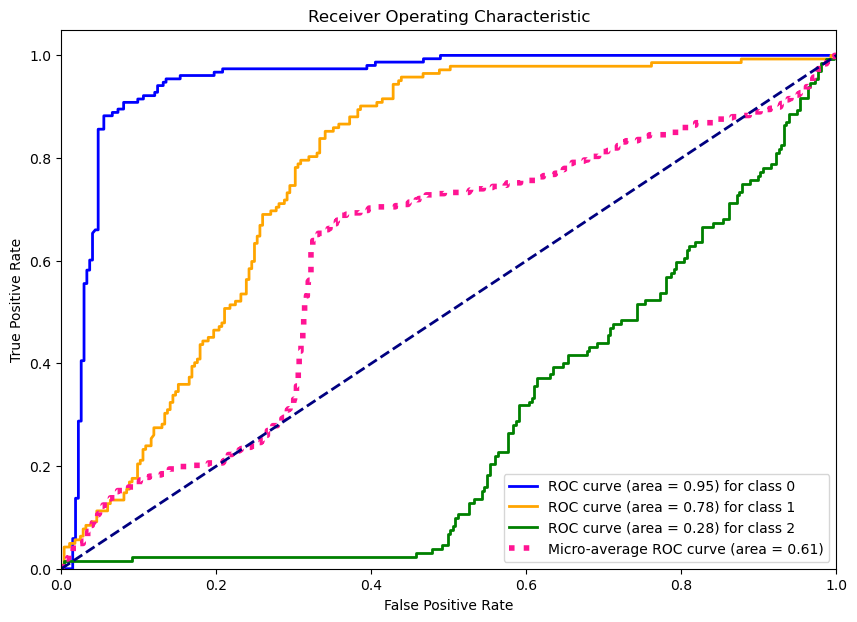

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_roc(y_test, y_pred_probs, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 7))
    colors = ['blue', 'orange', 'green']  # Add more colors if needed

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=4,
             label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Load your test data (x_test and y_test) before calling this function
model = create_model_with_attention()
y_pred_probs = model.predict(x_test)
num_classes = 3  # Adjust this based on your number of classes
plot_roc(y_test, y_pred_probs, num_classes)


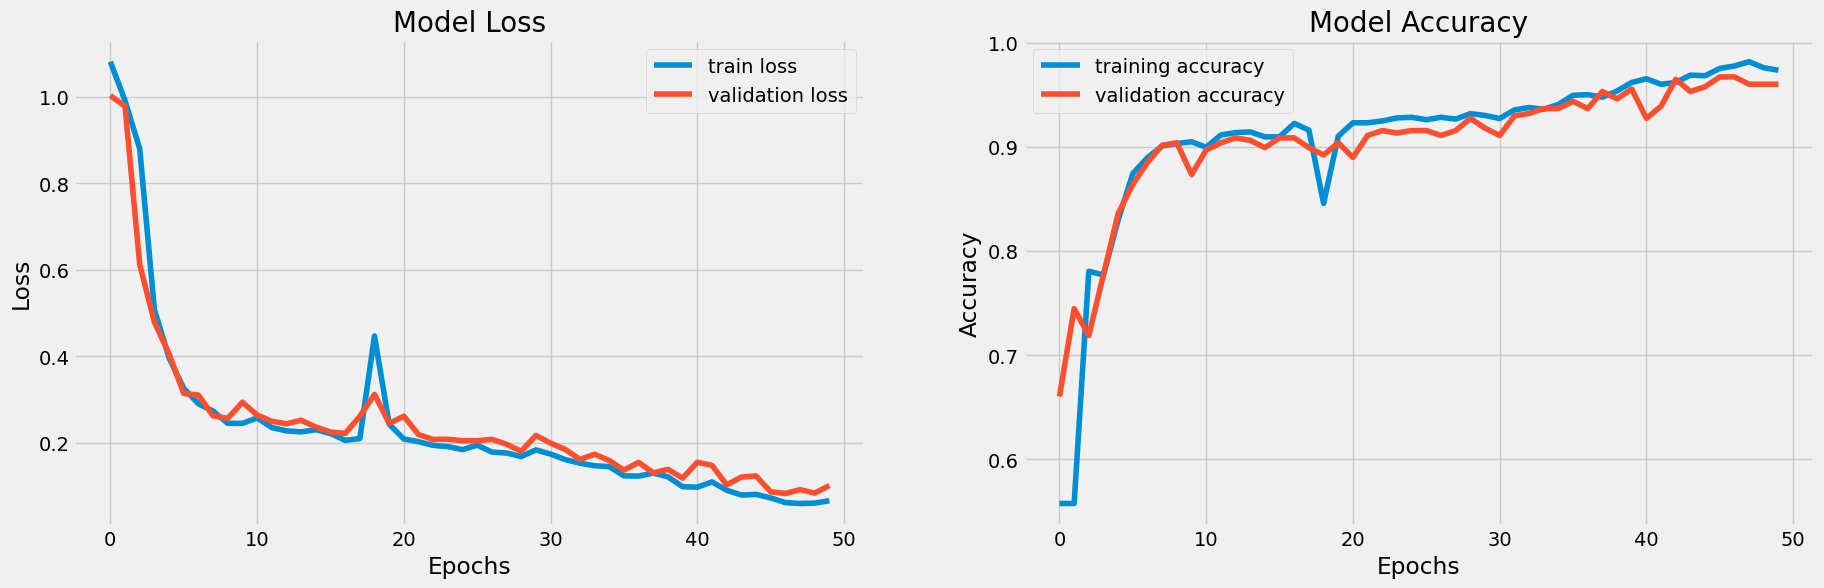

In [37]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

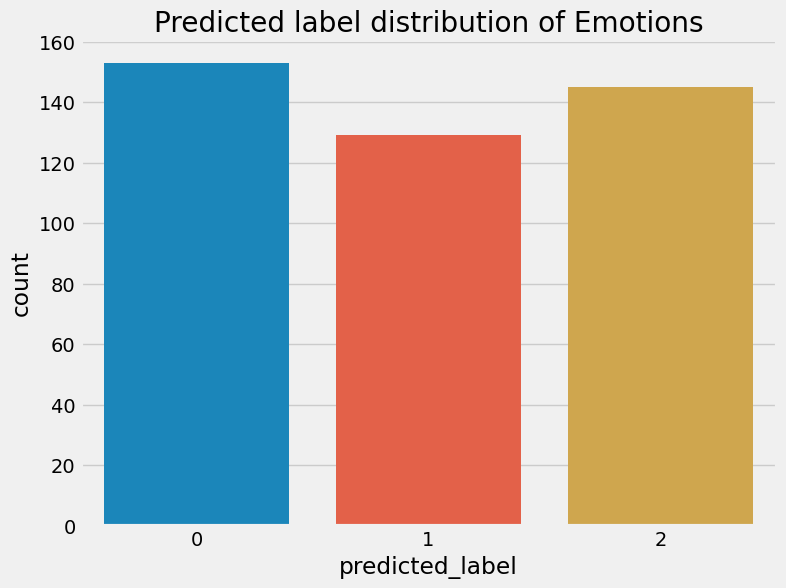

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already computed and stored the 'pred1' variable containing the predicted labels

# Convert the 'pred1' NumPy array to a DataFrame with a new column 'predicted_label'
df_pred = pd.DataFrame({'predicted_label': pred1})

# Plot the predicted label distribution using Seaborn countplot
plt.figure(figsize=(8, 6))
plt.title("Predicted label distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='predicted_label', data=df_pred)
plt.show()


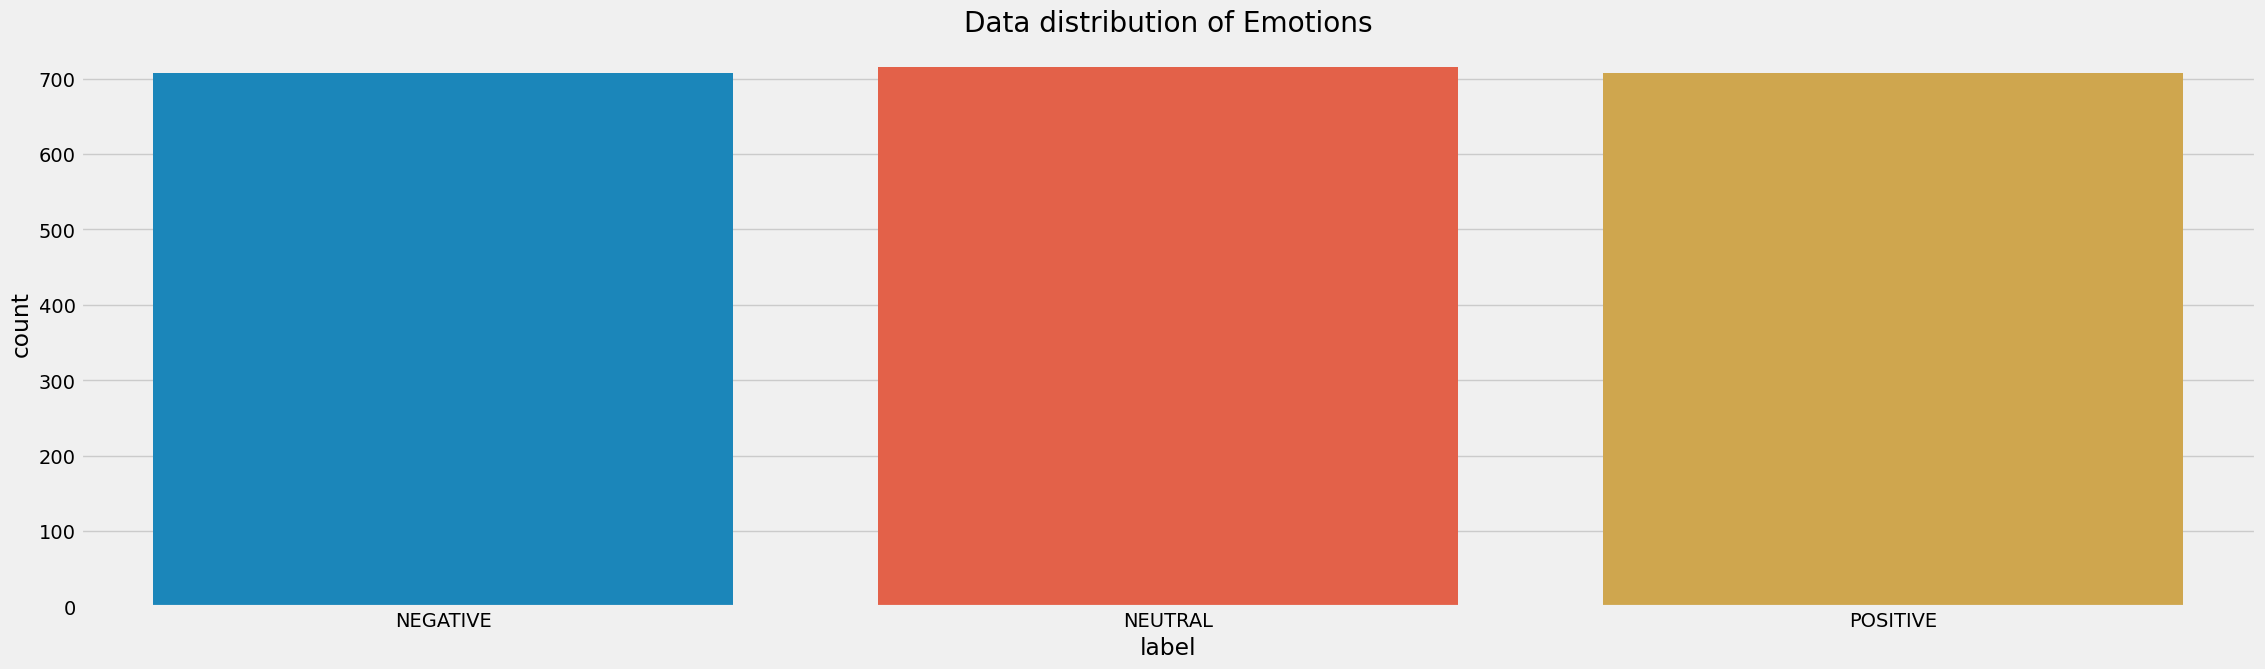

In [39]:
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

In [40]:
'''''!pip install --upgrade scikit-learn
!pip install nltk
from nltk.data import LazyLoader
#from nltk.translate import bleu
#from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

#from nltk.translate.bleu_score import corpus_bleu

# Read the TXT file and split it into lines (each line contains one reference and one predicted sentence)
with open('/content/drive/MyDrive/result.txt', 'r') as file:
    lines = file.readlines()

#def is_non_empty(sentence):
   # return bool(sentence and sentence.strip())

# Extract the reference and predicted sentences from the lines
reference_dataset = []
predicted_dataset = []

for line in lines:
    elements = line.strip().split('\t')
    if len(elements) == 2:
        reference, predicted = elements
        reference_dataset.append(reference)
        predicted_dataset.append(predicted)
    else:
        # Handle cases where a line may not contain both reference and predicted sentences
        print("Skipping line:", line.strip())

# Convert the reference and predicted datasets into lists of lists of tokens (words or subwords)
reference_tokens = [[sentence.split()] for sentence in reference_dataset]
predicted_tokens = [sentence.split() for sentence in predicted_dataset]

epsilon_token = "<EMPTY>"
def replace_empty_sentences(sentences, epsilon_token):
    return [epsilon_token if not sentence.strip() else sentence for sentence in sentences]
# Replace empty sentences in reference_dataset
reference_dataset = replace_empty_sentences(reference_dataset, epsilon_token)

# Replace empty sentences in predicted_dataset
predicted_dataset = replace_empty_sentences(predicted_dataset, epsilon_token)


# Calculate BLEU-1, BLEU-2, and BLEU-4 scores for the entire datasets
bleu_1_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(1,0,0,0))
bleu_2_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.5, 0 , 0))
bleu_3_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.25, 0.25, 0))
bleu_4_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print the BLEU scores
print("BLEU-1 score:", bleu_1_score)
print("BLEU-2 score:", bleu_2_score)
print("BLEU-3 score:", bleu_3_score)
print("BLEU-4 score:", bleu_4_score)'''


'\'\'!pip install --upgrade scikit-learn\n!pip install nltk\nfrom nltk.data import LazyLoader\n#from nltk.translate import bleu\n#from nltk.translate.bleu_score import sentence_bleu\nfrom nltk.translate.bleu_score import corpus_bleu\n\n#from nltk.translate.bleu_score import corpus_bleu\n\n# Read the TXT file and split it into lines (each line contains one reference and one predicted sentence)\nwith open(\'/content/drive/MyDrive/result.txt\', \'r\') as file:\n    lines = file.readlines()\n\n#def is_non_empty(sentence):\n   # return bool(sentence and sentence.strip())\n\n# Extract the reference and predicted sentences from the lines\nreference_dataset = []\npredicted_dataset = []\n\nfor line in lines:\n    elements = line.strip().split(\'\t\')\n    if len(elements) == 2:\n        reference, predicted = elements\n        reference_dataset.append(reference)\n        predicted_dataset.append(predicted)\n    else:\n        # Handle cases where a line may not contain both reference and predic

In [41]:
''''!pip install --upgrade scikit-learn
!pip install rouge
!pip install --upgrade nltk
from nltk.data import LazyLoader
import nltk

epsilon_token = "<EMPTY>"

#import nltk
#nltk.download('punkt')  # Download the Punkt tokenizer for sentence splitting

def read_txt_file(file_path,epsilon_token):
    # Initialize an empty list to store sentences
    sentences = []

    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    return sentences

# Replace 'your_file.txt' with the path to your text file
file_path = '/content/result.txt'
sentences = read_txt_file(file_path , epsilon_token)

# Print the sentences
for idx, sentence in enumerate(sentences, start=1):
    print(f"Sentence {idx}: {sentence}")


def replace_empty_sentences(sentences,epsilon_token):
    return [epsilon_token if not sentence.strip() else sentence for sentence in sentences]
reference_dataset = []
predicted_dataset = []

for line in lines:
    elements = line.strip().split('\t')
    if len(elements) == 2:
        reference, predicted = elements
        reference_dataset.append(reference)
        predicted_dataset.append(predicted)

reference_dataset = replace_empty_sentences(reference_dataset, epsilon_token)

predicted_dataset = replace_empty_sentences(predicted_dataset, epsilon_token)

bleu_scores = [sentence_bleu([reference], predicted) for reference, predicted in zip(reference_dataset, predicted_dataset)]

from rouge import Rouge

rouge = Rouge()

rouge_scores = [rouge.get_scores(predicted, reference)[0]['rouge-1']['f'] for reference, predicted in zip(reference_dataset, predicted_dataset)]

non_epsilon_bleu_scores = [score for score in bleu_scores if score != 0]

non_epsilon_rouge_scores = [score for score in rouge_scores if score != 0]

average_bleu_score = sum(non_epsilon_bleu_scores) / len(non_epsilon_bleu_scores)

average_rouge_score = sum(non_epsilon_rouge_scores) / len(non_epsilon_rouge_scores)

# Print the average scores
print(f"Average BLEU score: {average_bleu_score}")
print(f"Average ROUGE score: {average_rouge_score}")'''

'\'!pip install --upgrade scikit-learn\n!pip install rouge\n!pip install --upgrade nltk\nfrom nltk.data import LazyLoader\nimport nltk\n\nepsilon_token = "<EMPTY>"\n\n#import nltk\n#nltk.download(\'punkt\')  # Download the Punkt tokenizer for sentence splitting\n\ndef read_txt_file(file_path,epsilon_token):\n    # Initialize an empty list to store sentences\n    sentences = []\n\n    # Read the text file\n    with open(file_path, \'r\', encoding=\'utf-8\') as file:\n        text = file.read()\n\n    # Tokenize the text into sentences\n    sentences = nltk.sent_tokenize(text)\n\n    return sentences\n\n# Replace \'your_file.txt\' with the path to your text file\nfile_path = \'/content/result.txt\'\nsentences = read_txt_file(file_path , epsilon_token)\n\n# Print the sentences\nfor idx, sentence in enumerate(sentences, start=1):\n    print(f"Sentence {idx}: {sentence}")\n\n\ndef replace_empty_sentences(sentences,epsilon_token):\n    return [epsilon_token if not sentence.strip() else sente

In [42]:
''''print("Contents of list_of_references:")
for sentences in reference_dataset:
    print(sentences)

print("\nContents of hypotheses:")
for sentences in predicted_dataset:
    print(sentences)

# Check if the lists are not empty
if not reference_dataset or not predicted_dataset:
    print("\nError: Either list_of_references or hypotheses is empty.")
    exit()

# Check if list_of_references is a list of lists
if not all(isinstance(refs, list) for refs in reference_dataset):
    print("\nError: list_of_references is not a list of lists.")
    exit()

# Check if hypotheses is a list of lists
if not all(isinstance(hypothesis, list) for hypothesis in predicted_dataset):
    print("\nError: hypotheses is not a list of lists.")
    exit()'''

'\'print("Contents of list_of_references:")\nfor sentences in reference_dataset:\n    print(sentences)\n\nprint("\nContents of hypotheses:")\nfor sentences in predicted_dataset:\n    print(sentences)\n\n# Check if the lists are not empty\nif not reference_dataset or not predicted_dataset:\n    print("\nError: Either list_of_references or hypotheses is empty.")\n    exit()\n\n# Check if list_of_references is a list of lists\nif not all(isinstance(refs, list) for refs in reference_dataset):\n    print("\nError: list_of_references is not a list of lists.")\n    exit()\n\n# Check if hypotheses is a list of lists\nif not all(isinstance(hypothesis, list) for hypothesis in predicted_dataset):\n    print("\nError: hypotheses is not a list of lists.")\n    exit()'

In [43]:
'''''from nltk.translate.bleu_score import sentence_bleu

# Assuming you have the list_of_references and hypotheses as valid lists of lists of tokens (words or subwords)

# Calculate ROUGE-1 score for the entire dataset
rouge_1_score = 0.0
num_samples = len(reference_dataset)

for references, hypothesis in zip(reference_dataset, predicted_dataset):
    reference_tokens = [reference.split() for reference in reference_dataset]
    hypothesis_tokens = hypothesis.split()

    # Calculate ROUGE-1 score for each sample
    rouge_1_score += sentence_bleu(reference_tokens, hypothesis_tokens, weights=(1, 0, 0))

# Average ROUGE-1 score over all samples
rouge_1_score /= num_samples

# Print the ROUGE-1 score
print("ROUGE-1 score:", rouge_1_score)
'''''''

SyntaxError: incomplete input (1945532251.py, line 21)

In [ ]:
# from rouge import Rouge

# # Initialize the Rouge object
# rouge = Rouge()
# file_path = "/content/reference_dataset.txt"
# with open(file_path, 'r', encoding='utf-8') as file:
#     # Read the content of the file
#     reference_dataset = file.read()
# file_path = "/content/predicted_dataset.txt"
# with open(file_path, 'r', encoding='utf-8') as file:
#     # Read the content of the file
#     predicted_dataset = file.read()


# # Calculate ROUGE-1 score for each sample and store them in a list
# rouge_1_scores = [rouge.get_scores(predicted, reference)[0]['rouge-1']['f'] for reference, predicted in zip(reference_dataset, predicted_dataset)]

# # Calculate the sum of ROUGE-1 scores
# total_rouge_1_score = sum(rouge_1_scores)

# # Calculate the number of valid samples (non-zero ROUGE-1 scores)
# num_valid_samples = len([score for score in rouge_1_scores if score != 0])

# # Calculate the average ROUGE-1 score (avoid division by zero)
# if num_valid_samples > 0:
#     average_rouge_1_score = total_rouge_1_score / num_valid_samples
# else:
#     average_rouge_1_score = 0.0'

# # Print the average ROUGE-1 score
# print(f"Average ROUGE-1 score: {average_rouge_1_score}")
